# 2. Image classification with CNN
* cnn을 이용하여 다음 이미지를 분류하여라.
* 인풋 데이터는 rgb 정보를 가지고 있다.
* 코드, 결과, 보고서를 함께 제출하여야 한다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [2]:
EPOCHS = 200 # 반복 횟수
BATCH_SIZE = 64 # 배치 크기

In [3]:
#pytorch를 통한 데이터 로드
train_loader = torch.utils.data.DataLoader(
datasets.CIFAR10('./.data', 
                 train = True,
                 download = True,
                 transform = transforms.Compose([
                   transforms.RandomCrop(32, padding = 4), # 과적합 방지를 위해 이미지를 랜덤으로 아무데나 잘라 32 크기로 출력
                   transforms.RandomHorizontalFlip(), # 과적합 방지를 위해 이미지를 랜덤으로 좌우반전
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), # loss계산을 위한 데이터 정규화
                                        (0.5, 0.5, 0.5))])),
    batch_size = BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(
datasets.CIFAR10('./.data', 
                 train = False,
                 download = True,
                 transform = transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), # loss계산을 위한 데이터 정규화
                                        (0.5, 0.5, 0.5))])),
    batch_size = BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader

In [5]:
test_loader

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 4) # 첫 번째 Convolution Layer
        self.conv2 = nn.Conv2d(16, 64, kernel_size = 4) # 두 번째 Convolution Layer
        self.pool = nn.MaxPool2d(2, 2) # Pooling Layer
        self.conv_drop = nn.Dropout2d() # 과적합 방지를 위한 Dropout Layer
        self.fc1 = nn.Linear(1600, 800) # 첫 번째 Fully Connected Layer
        self.fc2 = nn.Linear(800, 400) # 두 번째 Fully Connected Layer
        self.fc3 = nn.Linear(400, 10) # 세 번째 Fully Connected Layer
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Convolution1 → ReLU 적용 → Pooling
        x = self.pool(F.relu(self.conv_drop(self.conv2(x)))) # Convolution2 → Dropout → ReLU 적용 → Pooling
        x = x.view(x.size(0), -1) # view 함수를 이용하여 텐서 x를 1차원으로 변경
        x = F.relu(self.fc1(x)) # Fully Connected1 → Relu 적용
        x = F.dropout(x, training = self.training) # 과적합 방지를 위한 Dropout Layer
        x = F.relu(self.fc2(x)) # Fully Connected2 → ReLU 적용
        x = self.fc3(x) # Fully Connected3
        return x

In [7]:
model = Net() # model을 Net으로 정의
optimizer = optim.SGD(model.parameters(), lr = 0.01) # optimizer를 SGD를 활용하고 Learning Rate = 0.01

model # model 확인

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=10, bias=True)
)

In [8]:
# training
def train(model, train_loader, optimizer, epoch):
    model.train() # model을 train하도록 설정
    for batch_idx, (data, target) in enumerate(train_loader): # train_loader의 배치를 가져와 데이터와 타겟을 설정
        optimizer.zero_grad() # 미분값을 0으로 설정
        output = model(data) # model에 data를 넣고 결과값을 output으로 정의
        loss = F.cross_entropy(output, target) # output과 target을 cross_entropy를 적용하여 loss계산
        loss.backward() # 오차역전파
        optimizer.step() # optimizer의 step 함수를 호출하여 매개변수 갱신

In [9]:
# evaluate
def evaluate(model, test_loader):
    model.eval() # model의 training을 방지 ex) Drop Out을 turn off
    test_loss = 0 # test loss를 0으로 설정
    correct = 0 # correct를 0으로 설정
    with torch.no_grad(): # evaluate에서 미분값을 더이상 자동으로 트래킹하지 않음
        for data, target in test_loader: # test_loader의 배치를 가져와 데이터와 타겟을 설정
            output = model(data) # model에 data를 넣고 결과값을 output으로 정의
            
            test_loss += F.cross_entropy(output, target,
                                        reduction = 'sum').item() # loss를 cross_entropy를 통하여 계산
            
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() # accuracy계산을 위해 data, target의 정답률 계산
            
        test_loss /= len(test_loader.dataset) # epoch의 loss를 계산
        test_accuracy = 100. * correct / len(test_loader.dataset) # epoch의 accuracy를 계산
        return test_loss, test_accuracy # test_loss, test_accuracy 출력

In [10]:
epochs = []
Test_loss = []      # 데이터 분석을 위한 epochs, Test_loss, Test_accuracy 레이어 생성
Test_accuracy = []

for epoch in range(1, EPOCHS + 1):
    
    train(model, train_loader, optimizer, epoch) # model을 통한 학습
    test_loss, test_accuracy = evaluate(model, test_loader) # model 검증
    
    print('[{}] Test Loss : {:.4f}, Accuracy: {:.2f}%'.format(
    epoch, test_loss, test_accuracy)) # epoch, test_loss, test_accuracy를 각 epoch마다 출력
    
    epochs.append(epoch)
    Test_loss.append(test_loss)          # 데이터 분석을 위한 epochs, Test_loss, Test_accuracy 레이어에 값 입력
    Test_accuracy.append(test_accuracy)

[1] Test Loss : 2.2478, Accuracy: 18.69%
[2] Test Loss : 2.0076, Accuracy: 26.82%
[3] Test Loss : 1.8910, Accuracy: 30.37%
[4] Test Loss : 1.7412, Accuracy: 35.91%
[5] Test Loss : 1.6331, Accuracy: 40.12%
[6] Test Loss : 1.5760, Accuracy: 42.43%
[7] Test Loss : 1.5318, Accuracy: 43.53%
[8] Test Loss : 1.4892, Accuracy: 46.07%
[9] Test Loss : 1.4694, Accuracy: 46.92%
[10] Test Loss : 1.4450, Accuracy: 46.73%
[11] Test Loss : 1.4154, Accuracy: 49.26%
[12] Test Loss : 1.3848, Accuracy: 50.04%
[13] Test Loss : 1.3629, Accuracy: 50.12%
[14] Test Loss : 1.3354, Accuracy: 52.70%
[15] Test Loss : 1.3165, Accuracy: 53.06%
[16] Test Loss : 1.3042, Accuracy: 53.50%
[17] Test Loss : 1.2866, Accuracy: 54.78%
[18] Test Loss : 1.2724, Accuracy: 55.63%
[19] Test Loss : 1.2638, Accuracy: 54.74%
[20] Test Loss : 1.2218, Accuracy: 56.99%
[21] Test Loss : 1.2059, Accuracy: 57.27%
[22] Test Loss : 1.2102, Accuracy: 57.88%
[23] Test Loss : 1.1856, Accuracy: 58.64%
[24] Test Loss : 1.1673, Accuracy: 59.26%
[

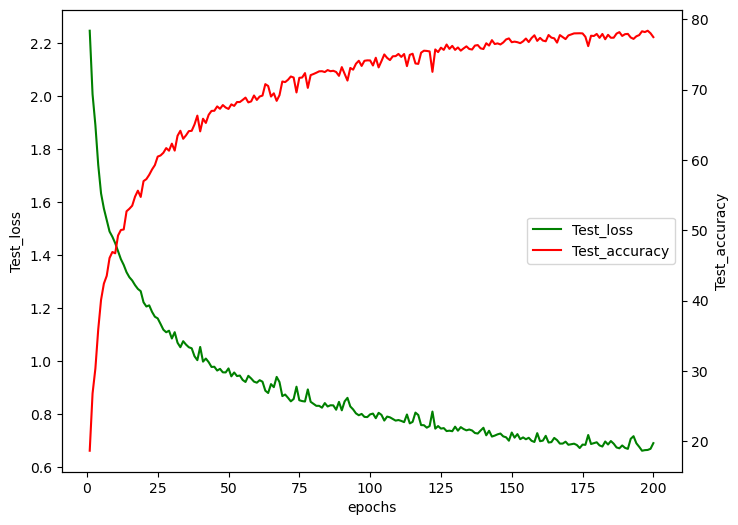

In [20]:
# 그래프를 통한 loss, accuracy 개요
import matplotlib.pyplot as plt

plt.style.use('default') # 그래프 스타일 default로 설정
plt.rcParams['figure.figsize'] = (8, 6) # 그래프 사이즈 (8, 6)으로 설정

x = epochs
y1 = Test_loss      # x, y1, y2 설정
y2 = Test_accuracy

fig, ax1 = plt.subplots() # 하나의 그래프로 표현하기 위해 subplots 이용
ax1.set_xlabel('epochs') # x 설정
ax1.set_ylabel('Test_loss') # y1 설정
line1 = ax1.plot(x, y1, color='green', label='Test_loss') # y1의 색 설정

ax2 = ax1.twinx() # 하나의 그래프로 표현하기 위해 twinx 이용
ax2.set_ylabel('Test_accuracy') # y2 설정
line2 = ax2.plot(x, y2, color='red', label='Test_accuracy') # y2의 색 설정

lines = line1 + line2 # 두 선을 합침
labels = [l.get_label() for l in lines] # 범주를 묶어서 표시
ax1.legend(lines, labels, loc='center right') # 범주의 색, 이름, 위치 설정
plt.show()

CIFAR-10 데이터는 RGB값을 갖고 있기 때문에 세 개의 채널로 나누어진다. 따라서 데이터를 불러오는 과정에 있어서 각 채널에 평균 0.5 표준편차 0.5를 적용하여 -1 ~ 1의 값으로 정규화 해주었다. 또한 과적합을 방지하기 위하여 데이터를 불러오는 과정에서 RandomCrop, RandomHorizontalFlip을 이용하여 이미지에 무작위 적인 가공을 해주었다. 학습을 위하여 CNN을 2개의 Convolution Layer, 2개의 Pooling Layer, 과적합 방지를 위한 Dropout Layer, 3개의 Fully Connected Layer를 설정하여 주었으며 이를 1차원으로 바꿔 주기 위하여 veiw를 이용하였다. 이 때 ReLU를 이용하여 학습을 진행하였다. 이러한 모델을 형성하여 Convolution1 → ReLU 적용 → Pooling → Convolution2 → Dropout → ReLU 적용 → Pooling → Fully Connected1 → Relu 적용 → view 함수를 이용하여 텐서 x를 1차원으로 변경 → 과적합 방지를 위한 Dropout Layer → Fully Connected2 → ReLU 적용 → Fully Connected3의 순으로 학습을 진행 시켰다. 이러한 학습의 결과를 테스트 데이터에 적용 시켜 loss와 accuracy를 구한 결과 loss 최소 0.6610, accuracy 최대 78.35%의 결과를 볼 수 있었다. 이는 학습용 데이터를 통해 학습한 모델이 테스트 데이터에 적용되었을 때 정확도를 보여주는데 epoch에 따른 결과를 보면 학습이 진행될수록 accuracy, loss의 변화율은 떨어지고 있어 현재 값에서 크게 변하지 않을 것으로 보인다. accuracy를 향상시키기 위해서는 Optimizer SGD를 ADAM으로 교체하고 scheduler를 통하여 Learning rate를 조절하여 Optimizer의 보폭을 조절해주어야 할 것 같다. 또한 CNN에 대하여 공부하던 중 알게 된 ResNet과 같은 CNN을 이용하면 더욱 좋은 결과를 얻을 수 있을 것이라 생각하여 실제 찾아본 결과 ResNet을 이용하였을 때 95.0%의 accuracy를 보였다. 이를 통해서 CNN의 형성이 얼마나 학습에 중요한 요인으로 작용하는지 이번 결과와 비교하며 알 수 있었다.